## House Price Prediction - Assignment Solution

### Brief Description

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

### Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading the dataset
house = pd.read_csv("train.csv", na_values="NAN")

In [ ]:
# Let's take a look at the first few rows
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
!pip install sweetviz

In [ ]:
#Auto EDA
import sweetviz as sv
sweet_report = sv.analyze(house,pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# Summary of the dataset : 1460 rows, 81 columns

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

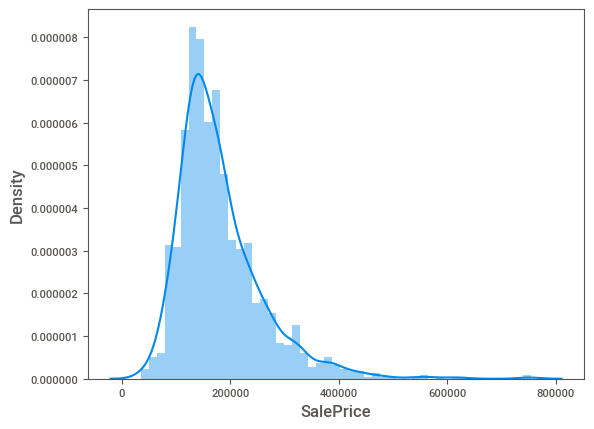

In [ ]:
sns.distplot(house['SalePrice'])

In [ ]:
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


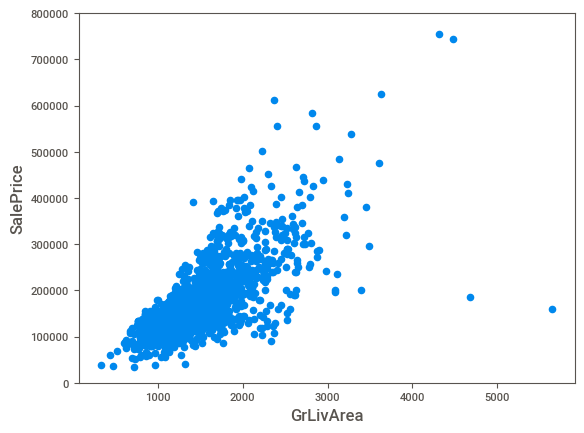

In [ ]:
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

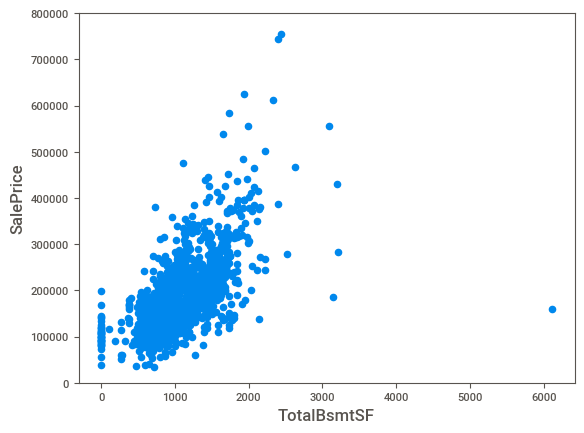

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

<AxesSubplot: xlabel='SalePrice'>

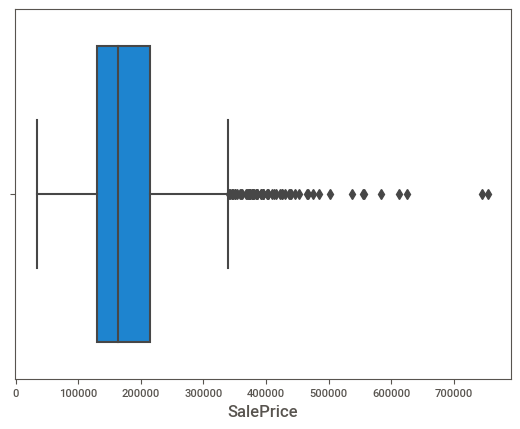

In [ ]:
sns.boxplot(data['SalePrice'])

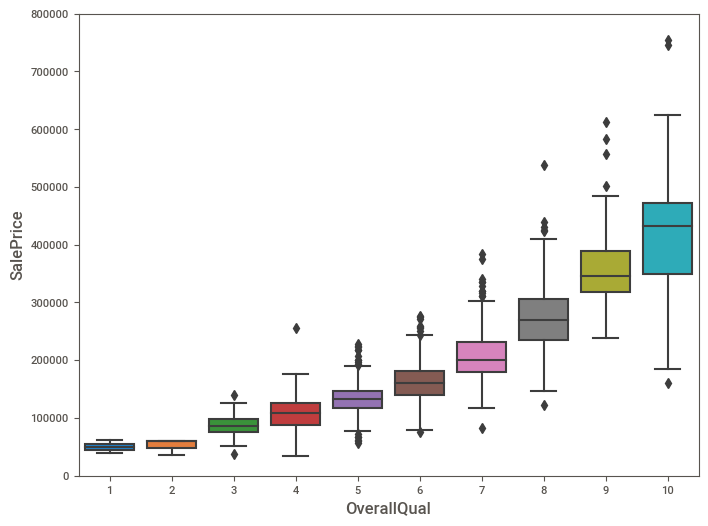

In [ ]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

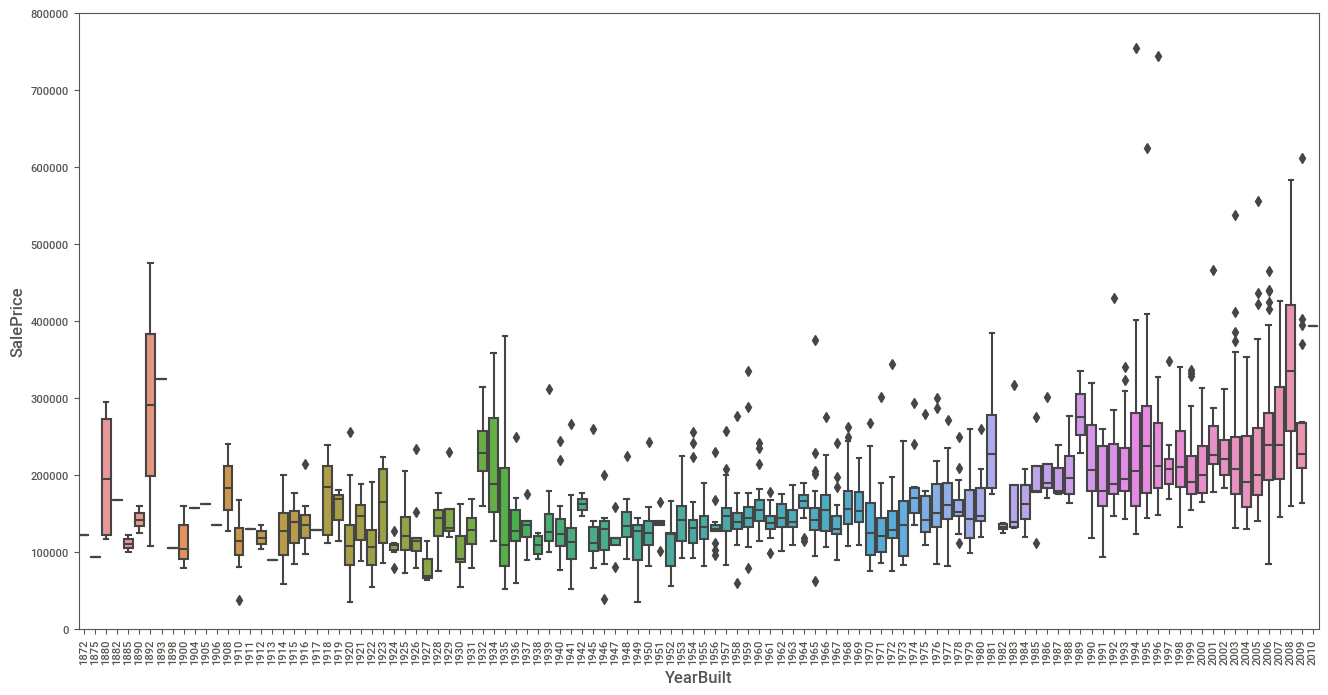

In [ ]:
var = 'YearBuilt'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

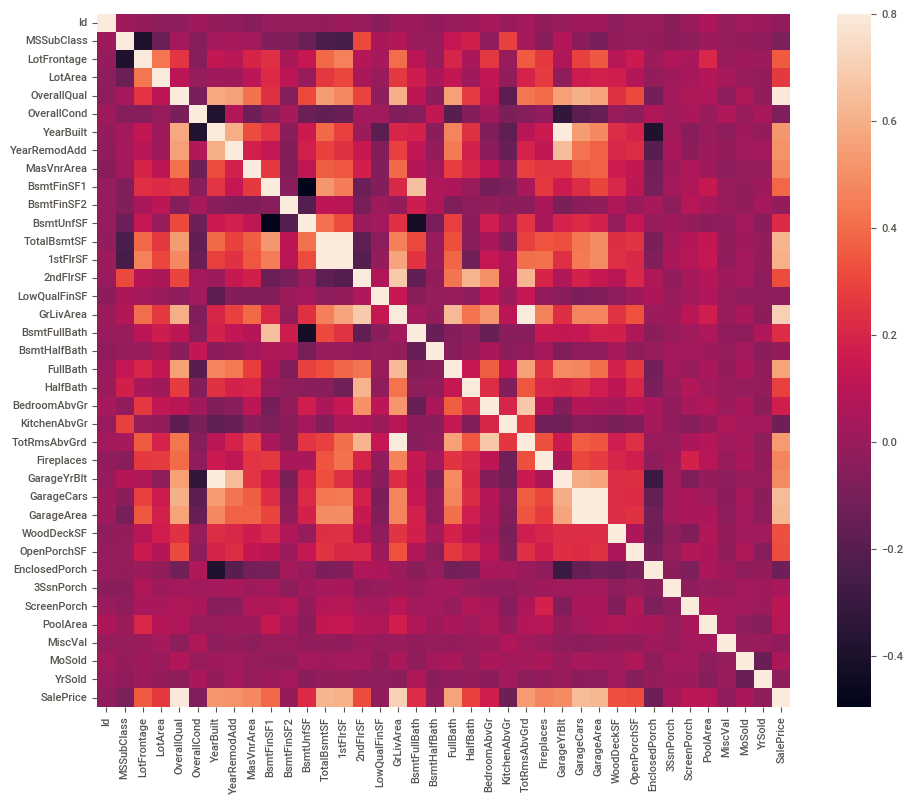

In [ ]:
#correlation matrix
corrmat = house.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

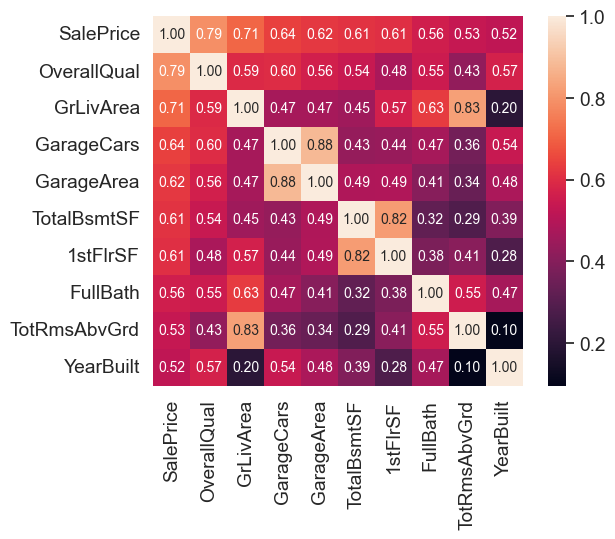

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

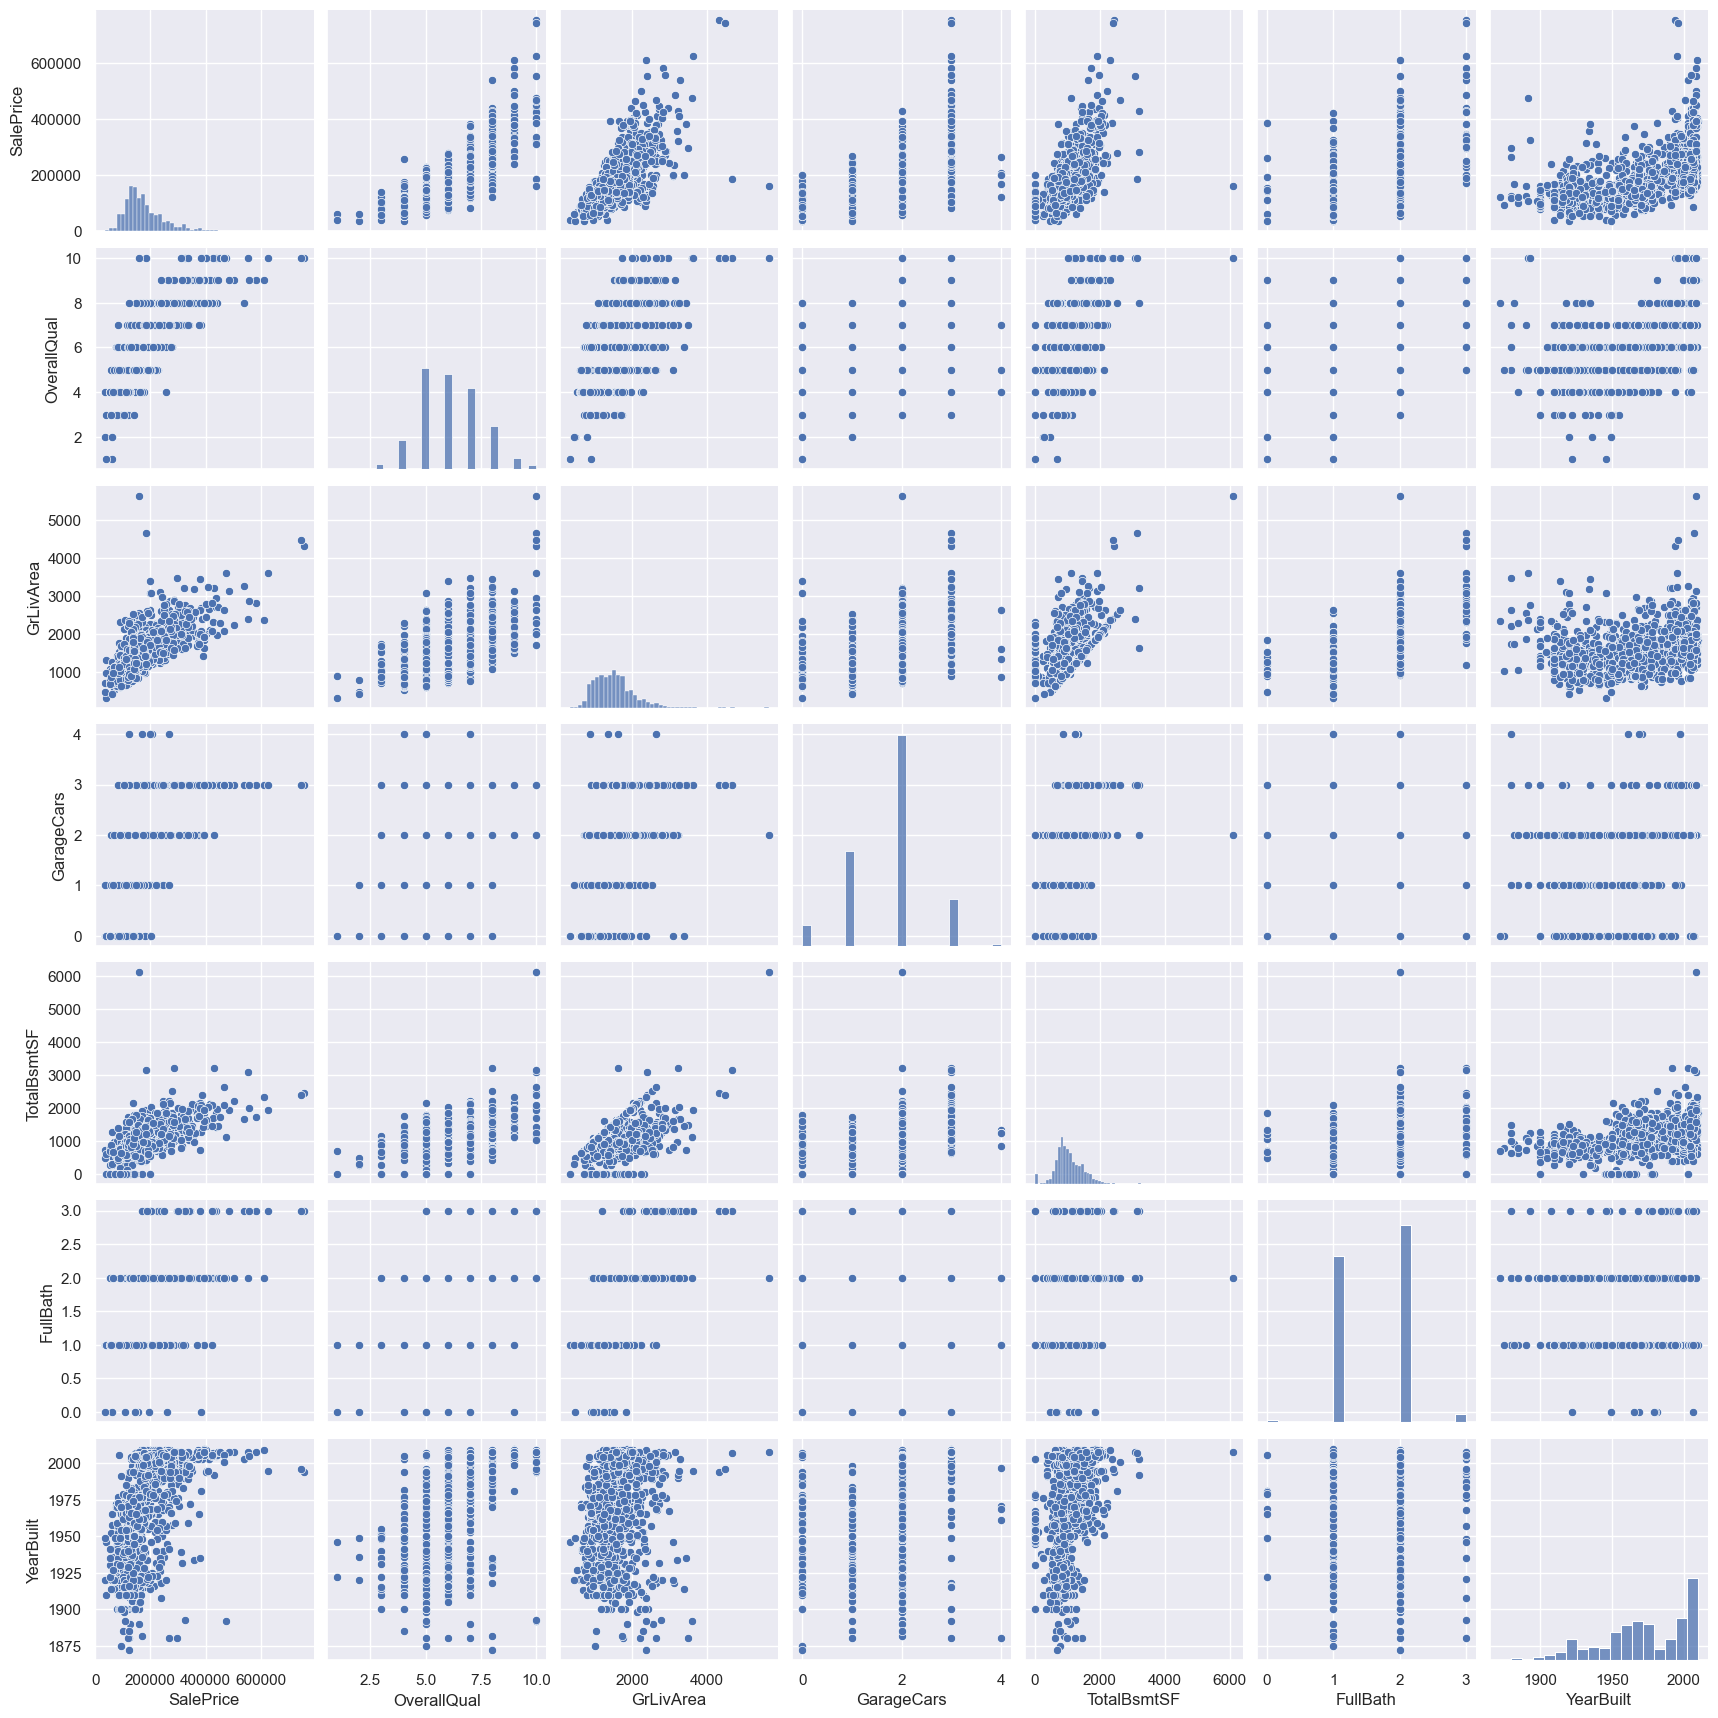

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

# Missing data

Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


## Imputing Null Values
With data this large, it is not surprising that there are a lot of missing values in the cells. In order to effectively train our model we build, we must first deal with the missing values. There are missing values for both numerical and categorical data. We will see how to deal with both.

For numerical imputing, we would typically fill the missing values with a measure like median, mean, or mode. For categorical imputing, I chose to fill the missing values with the most common term that appeared from the entire column. There are other ways to do the imputing though, and I ecnourage you to test out your own creative ways!

### Places Where NaN Means Something
If you look at the data description file provided, you will see that for some categories, NaN actually means something. This means that if a value is NaN, the house might not have that certain attribute, which will affect the price of the house. Therefore, it is better to not drop, but fill in the null cell with a value called "None" which serves as its own category.

In [ ]:
#you can find these features on the description data file provided

null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [ ]:
for i in null_has_meaning:
    house[i].fillna("None", inplace=True)
    house[i].fillna("None", inplace=True)

In [ ]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Imputing "Real" NaN Values

These are the real NaN values that we have to deal with accordingly because they were not recorded.

In [ ]:
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy="median")

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


LotFrontage has too many Null values and it is a numerical value so it may be better to just drop it.

In [ ]:
house.drop("LotFrontage", axis=1, inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


GarageYrBlt, MasVnrArea, and MasVnrType all have a fairly decent amount of missing values. MasVnrType is categorical so we can replace the missing values with "None", as we did before. We can fill the others with median.

In [ ]:
house["GarageYrBlt"].fillna(house["GarageYrBlt"].median(), inplace=True)
house["MasVnrArea"].fillna(house["MasVnrArea"].median(), inplace=True)
house["MasVnrType"].fillna("None", inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Electrical,1,0.000685
MSSubClass,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


Now that only one row has a null entry, we will drop the row.

In [ ]:
house.dropna(inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [ ]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [ ]:
#Auto EDA
import sweetviz as sv
sweet_report = sv.analyze(house,pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Now we will determine the data type of all features remaining

In [ ]:
types_train = house.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

In [ ]:
pd.DataFrame(types_train).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      35
float64     2
Name: 0, dtype: int64

In [ ]:
#we should convert num_train to a list to make it easier to work with
numerical_values_train = list(num_train.index)

In [ ]:
print(numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


These are all the numerical features in our data.

In [ ]:
categorical_values_train = list(cat_train.index)
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


These are all the caregorical features in our data.

# Data Preparation

Ok, now that we have dealt with all the missing values, it looks like it's time for some feature engineering, the second part of our data preprocessing. We need to create feature vectors in order to get the data ready to be fed into our model as training data. This requires us to convert the categorical values into representative numbers.

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

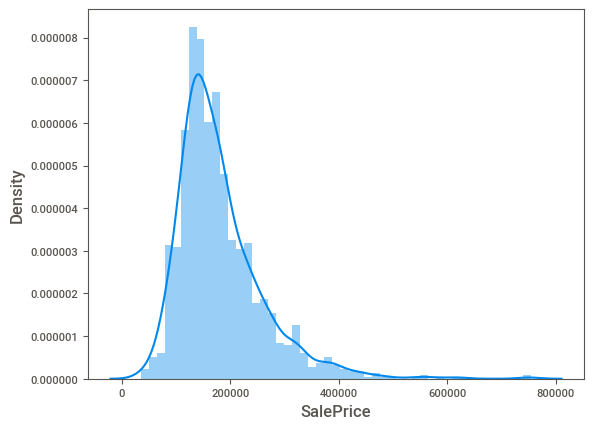

In [ ]:
sns.distplot(house["SalePrice"])

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

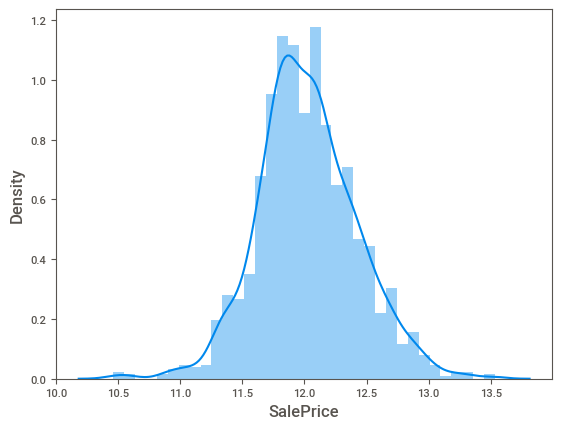

In [ ]:
sns.distplot(np.log(house["SalePrice"]))

It appears that the target, SalePrice, is very skewed and a transformation like a logarithm would make it more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets. By transforming the prices, we can boost model performance.

In [ ]:
house["TransformedPrice"] = np.log(house["SalePrice"])

In [ ]:
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [ ]:
for i in categorical_values_train:
    feature_set = set(house[i])
    for j in feature_set:
        feature_list = list(feature_set)
        house.loc[house[i] == j, i] = feature_list.index(j)

In [ ]:
house.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,1,8450,0,1,2,1,1,0,...,1,1,0,0,2,2008,0,5,208500,12.247694
1,2,20,1,9600,0,1,2,1,1,2,...,1,1,0,0,5,2007,0,5,181500,12.109011
2,3,60,1,11250,0,1,1,1,1,0,...,1,1,0,0,9,2008,0,5,223500,12.317167
3,4,70,1,9550,0,1,1,1,1,3,...,1,1,0,0,2,2006,0,4,140000,11.849398
4,5,60,1,14260,0,1,1,1,1,2,...,1,1,0,0,12,2008,0,5,250000,12.429216


Great! It seems like we have changed all the categorical strings into a representative number. We are ready to build our models!

# Model Building

Now that we've preprocessed and explored our data, we have a much better understanding of the type of data that we're dealing with. Now, we can began to build and test different models for regression to predict the Sale Price of each house.

In [ ]:
X = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values
y = house["TransformedPrice"].values

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [ ]:
#Unregularized Model
from sklearn.linear_model import LinearRegression,Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.9086430994440127
Testing R2
-0.022515851036292833


In [ ]:
#If alpha=0 then overfitting [Unregularised Model]
#Higher the alpha more the regularization more the underfitting
#Lower the alpha lesser the regularization more the overfitting
lr = Lasso(alpha=0.002)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.8823931994820794
Testing R2
0.8230748384207629


In [ ]:
lr.coef_

array([-7.05870525e-04, -2.22997659e-03,  2.11933542e-06, -0.00000000e+00,
       -1.66961004e-03,  0.00000000e+00, -2.50904299e-02,  0.00000000e+00,
        3.96188336e-04,  0.00000000e+00, -2.08499795e-03, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  7.49327030e-02,
        4.67083377e-02,  2.53711208e-03,  1.34640538e-03, -8.32825326e-03,
        2.70472018e-02,  2.78290045e-03, -2.19208976e-03, -0.00000000e+00,
        8.33688865e-06,  8.51244286e-03, -0.00000000e+00,  1.51487545e-02,
       -8.72637773e-03,  1.91601129e-02,  7.83802151e-03, -8.08377224e-03,
        7.52226768e-05,  7.26010331e-03,  7.66070142e-05,  5.01212114e-05,
        2.67373445e-05,  0.00000000e+00, -7.91313063e-03,  1.87171633e-02,
       -0.00000000e+00,  1.92677826e-04,  2.20697861e-04,  2.75714977e-04,
        2.86990539e-05,  4.19355349e-02,  0.00000000e+00,  2.08503099e-02,
        4.21398185e-03,  0.00000000e+00, -0.00000000e+00, -7.61659935e-03,
        2.46826090e-03, -

In [ ]:
# list of alphas to tune
params = {'alpha': [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [ ]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [ ]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.020316,0.007092,0.001660,0.000551,0.0,{'alpha': 1e-08},0.920100,0.879842,0.799796,0.901950,...,0.873257,0.041310,1,0.902485,0.910914,0.930189,0.907109,0.907384,0.911616,0.009665
1,0.019415,0.010672,0.002112,0.000485,0.0,{'alpha': 1e-07},0.920101,0.879842,0.799797,0.901630,...,0.873194,0.041265,2,0.902485,0.910914,0.930189,0.907108,0.907384,0.911616,0.009665
2,0.014845,0.010417,0.001446,0.000534,0.000001,{'alpha': 1e-06},0.920104,0.879846,0.799805,0.896318,...,0.872136,0.040580,3,0.902485,0.910914,0.930189,0.907101,0.907384,0.911615,0.009666
3,0.009643,0.001662,0.001403,0.000487,0.00001,{'alpha': 1e-05},0.920136,0.879882,0.799880,0.647911,...,0.822496,0.095496,5,0.902483,0.910912,0.930187,0.906947,0.907382,0.911582,0.009680
4,0.010136,0.002629,0.001542,0.000419,0.0001,{'alpha': 0.0001},0.919797,0.880101,0.800580,0.646988,...,0.822536,0.095806,4,0.902291,0.910733,0.930028,0.906857,0.907258,0.911434,0.009677


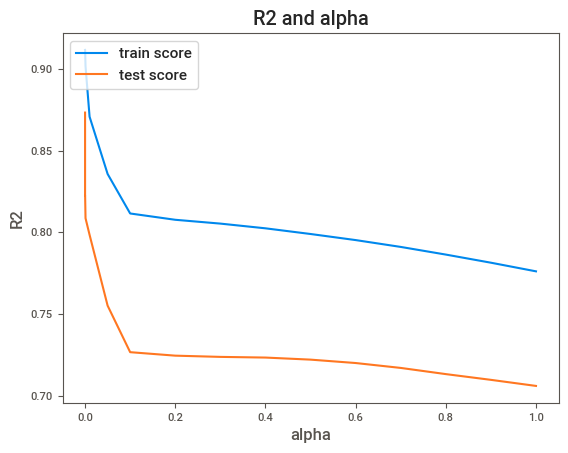

In [ ]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2')

plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
alpha = 50

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=50, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.coef_

array([-0.00000000e+00,  0.00000000e+00,  4.02426915e-06, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.41724335e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.68173575e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [ ]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.119847,0.226333,0.001607,0.001348,0.0001,{'alpha': 0.0001},-0.087071,-0.101646,-0.098407,-0.103790,...,-0.097286,0.005835,9,-0.085769,-0.082144,-0.076335,-0.084570,-0.083747,-0.082513,0.003306
1,0.003199,0.000731,0.000586,0.000479,0.001,{'alpha': 0.001},-0.087075,-0.101642,-0.098408,-0.103672,...,-0.097262,0.005807,8,-0.085772,-0.082147,-0.076335,-0.084573,-0.083749,-0.082515,0.003307
2,0.002770,0.000389,0.000611,0.000500,0.01,{'alpha': 0.01},-0.087114,-0.101606,-0.098413,-0.102847,...,-0.097100,0.005612,6,-0.085799,-0.082178,-0.076344,-0.084593,-0.083770,-0.082537,0.003313
3,0.002645,0.000502,0.000199,0.000398,0.05,{'alpha': 0.05},-0.087279,-0.101460,-0.098444,-0.101629,...,-0.096869,0.005294,3,-0.085918,-0.082316,-0.076388,-0.084628,-0.083864,-0.082623,0.003328
4,0.002598,0.000462,0.000384,0.000451,0.1,{'alpha': 0.1},-0.087496,-0.101295,-0.098484,-0.101213,...,-0.096812,0.005114,1,-0.086064,-0.082499,-0.076455,-0.084646,-0.083988,-0.082730,0.003340


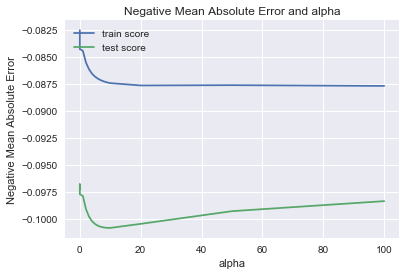

In [ ]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-5.20092641e-04,  1.60948169e-02,  1.59785620e-06, -6.05258033e-02,
       -3.25998698e-02,  1.06892333e-02,  2.25455423e-02, -1.03038498e-02,
        5.85721927e-03,  3.39343696e-02, -3.70348250e-04, -1.42030692e-02,
       -7.09301443e-02,  2.43593678e-03,  7.36355103e-03,  7.37037488e-02,
        4.66546673e-02,  1.97019403e-03,  9.31805522e-04, -2.14608844e-02,
       -3.53496500e-02, -1.30036171e-03,  2.22674053e-03,  3.68606196e-03,
        2.03130658e-05,  1.45471552e-02, -3.74901462e-03, -1.53689334e-02,
       -1.61232552e-03, -8.47033677e-03,  7.54356571e-03,  8.11722737e-03,
        3.28033412e-05, -4.90819903e-03,  2.37725324e-05,  5.74768203e-06,
        6.23235566e-05,  3.56064489e-03,  2.10453386e-03, -4.89829856e-02,
       -1.04609041e-03,  3.52224765e-05,  7.06198150e-05,  6.45626153e-05,
        1.70404904e-04,  5.71217176e-02,  1.69263908e-02,  3.86888190e-02,
        1.78673724e-02, -3.54664408e-04, -4.28230192e-02, -2.07035594e-02,
        1.10260493e-02, -